In [1]:
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle
from mytools import Video, get_cuts

2023-11-28 13:01:27.793727: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 13:01:27.852949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 13:01:27.853011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 13:01:27.853075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 13:01:27.864009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 13:01:27.864650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from icecream import ic
ic.disable()

# Define Spliter and Generator

## Used functions

In [3]:
def get_cuts_df(video, cuts, frames_before=2, frames_after=2):
    """
    Returns table of frames indices arround cuts.
    
    Parameters:
    video : mytools.Video
    
    cuts : int-array
    
    frames_before : int
    
    frames_after : int
    """
    df = np.arange(-frames_before, frames_after).reshape([1, frames_before + frames_after]) + cuts.reshape([len(cuts), 1])
    df = pd.DataFrame(df).astype(int)
    return df

In [4]:
def get_noncuts_df(video, cuts, frames_before=2, frames_after=2):
    """
    Returns table of frames indices arround noncuts.
    
    Parameters:
    video : mytools.Video
    
    cuts : int-array
    
    frames_before : int
    
    frames_after : int
    """
    noncuts = np.arange(len(video))
    noncuts = noncuts[np.logical_not(np.isin(noncuts, cuts))]
    noncuts = noncuts[noncuts >= frames_before]
    noncuts = noncuts[noncuts < len(video) - frames_after]
    df = np.arange(-frames_before, frames_after).reshape([1, frames_before + frames_after]) + noncuts.reshape([len(noncuts), 1])
    df = pd.DataFrame(df).astype(int)
    return df

In [5]:
def get_frames_from_row(row, videos, frames_before=2, frames_after=2, video_size=None, rescale=None):
    """
    """
    res = []
    for i in range(frames_before):
        res.append(videos[row['before']].get_frame(row[i], new_size=video_size))
    for i in range(frames_before, frames_before + frames_after):
        res.append(videos[row['after']].get_frame(row[i], new_size=video_size))
    res = np.array(res)
    if rescale is not None:
        res = res*rescale
    return res

## Iterator and Generator classes

In [6]:
class TableVideoIterator:
    def __init__(self, videos, df: pd.DataFrame, frames_before=2, frames_after=2, 
                 batch_size=64, video_size=None, rescale=None, shuffle=True):
        """
        Yields batches (X, y)
        
        Parameters:
        -----------
        videos : dict, with mytools.Video values
        
        df : pd.DataFrame, columns: 'before' - str, videos keys
                                    'after' - str, videos keys
                                    'cut' - bool, 
                                    0, 1, ..., (frames_before + frames_after - 1) - int
        
        frames_before : int
        
        frames_after : int
        
        batch_size : int
        
        video_size : None or tuple with 2 integers
            Change video size if not None
        
        
        """
        ic()
        self.videos = videos
        self.df = df.reset_index(drop=False)
        self.frames_before = frames_before
        self.frames_after = frames_after
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.rescale = rescale
        self.video_size = video_size
        self.indexes = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indexes)
        self.batch_index = 0
        
    def reshuffle(self):
        self.indexes = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return (len(self.df) - 1)//self.batch_size + 1
    
    def on_epoch_end(self):
        ic()
        self.batch_index = 0
        self.reshuffle()
        ic()
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError(
                "Asked to retrieve element {idx}, "
                "but the Sequence "
                "has length {length}".format(idx=idx, length=len(self))
            )
        if idx == len(self) - 1:
            indexes_i = self.indexes[idx*self.batch_size:]
        else:
            indexes_i = self.indexes[idx*self.batch_size:(idx + 1)*self.batch_size]
        X = []
        for i in indexes_i:
            X.append(get_frames_from_row(self.df.loc[i], self.videos, 
                                         frames_before=self.frames_before, 
                                         frames_after=self.frames_after, 
                                         video_size=self.video_size, 
                                         rescale=self.rescale))
        X = np.array(X)
        y = self.df.loc[indexes_i, 'cut'].values.astype(int)
        ic(X.shape, y.shape)
        return X, y
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.batch_index += 1
        if self.batch_index > len(self):
            ic()
            self.on_epoch_end()
            raise StopIteration
        return self[self.batch_index - 1]

In [7]:
class TableVideoGenerator:
    def __init__(self, videos, df: pd.DataFrame, frames_before=2, frames_after=2, 
                 batch_size=64, video_size=None, rescale=None):
        """
        """
        self.videos = videos
        self.df = df.copy()
        self.batch_size = batch_size
        self.rescale = rescale
        self.video_size = video_size
        self.frames_before = frames_before
        self.frames_after = frames_after
        
    def __len__(self):
        return (len(self.df) - 1)//self.batch_size + 1
    
    def flow(self):
        while True:
            ic()
            for X, y in TableVideoIterator(videos=self.videos, df=self.df, 
                                           frames_before=self.frames_before, frames_after=self.frames_after, 
                                           batch_size=self.batch_size, 
                                           video_size=self.video_size, rescale=self.rescale, shuffle=True):
                yield X, y
            ic()

## Spliter class

In [8]:
class Spliter:
    def __init__(self, video_paths, cuts_paths, frames_before=2, frames_after=2):
        """
        """
        if len(video_paths) != len(cuts_paths):
            raise ValueError("video_paths and cuts_paths have different lengths.")
        self.frames_before = frames_before
        self.frames_after = frames_after
        self.filenames = np.array(video_paths)
        self.videos = {}
        self.cuts = {}
        for i in range(len(video_paths)):
            self.videos.update({video_paths[i] : Video(video_paths[i])})
            self.cuts.update({video_paths[i] : get_cuts(cuts_paths[i])})
        self.df = pd.DataFrame(columns=['before', 'after', 'cut'])
        self.df = self.df.astype({'before' : str, 'after' : str, 'cut' : bool})
    
    def define_cuts(self):
        """
        """
        for filename in self.filenames:
            dfi = get_cuts_df(self.videos[filename], self.cuts[filename], 
                              frames_before=self.frames_before, frames_after=self.frames_after)
            dfi['cut'] = True
            dfi['before'] = filename
            dfi['after'] = filename
            self.df = pd.concat([self.df, dfi], ignore_index=True)
        for i in range(self.frames_before + self.frames_after):
            self.df = self.df.astype({i: int})
            
    def define_noncuts(self):
        """
        """
        for filename in self.filenames:
            dfi = get_noncuts_df(self.videos[filename], self.cuts[filename], 
                                 frames_before=self.frames_before, frames_after=self.frames_after)
            dfi['cut'] = False
            dfi['before'] = filename
            dfi['after'] = filename
            self.df = pd.concat([self.df, dfi], ignore_index=True)
        for i in range(self.frames_before + self.frames_after):
            self.df = self.df.astype({i: int})
            
    def define(self, portion=1):
        """
        """
        self.define_cuts()
        self.define_noncuts()
        self.df = self.df.drop_duplicates()
        if portion < 1:
            n = len(self.df)
            idx = np.arange(n)
            idx = np.sort(np.random.choice(idx, int(portion*n)))
            self.df = self.df.loc[idx].reset_index(drop=True)
        
    def split(self, validation_portion=0.2):
        """
        """
        n = int(len(self.df)*validation_portion)
        idx = self.df.index.values
        np.random.shuffle(idx)
        self.df_validation = pd.DataFrame(self.df.values[idx[:n]], columns=self.df.columns)
        self.df_training = pd.DataFrame(self.df.values[idx[n:]], columns=self.df.columns)
    
    
    def len_training_cuts(self):
        # return number of cut-rows in training table
        return len(self.df_training[self.df_training['cut'] == True])
    
    def len_training_noncuts(self):
        # return number of noncut-rows in training table
        return len(self.df_training[self.df_training['cut'] == False])
    
    def len_validation_cuts(self):
        # return number of cut-rows in validation table
        return len(self.df_validation[self.df_validation['cut'] == True])
    
    def len_validation_noncuts(self):
        # return number of noncut-rows in validation table
        return len(self.df_validation[self.df_validation['cut'] == False])
    
    
    def augment_cuts(self, n=0, near_val=2):
        """
        Add augmentated cuts to training table.
        
        Parameters:
        -----------
        n : int
            Number of augmneting and adding cut-rows.
        
        near_val : int
            If cut is got from one video and the neighbou frames are in destace less n in original: remove that cut-rows.
        """
        df_noncut = self.df_training[self.df_training['cut'] == False].reset_index(drop=True)
        begins = np.random.randint(len(df_noncut), size=[n, 2])
        df_before = df_noncut.loc[begins[:, 0], np.append('before', np.arange(self.frames_before, dtype=object))].reset_index(drop=True)
        df_after = df_noncut.loc[begins[:, 1], np.append('after', np.arange(self.frames_before, self.frames_before + self.frames_after, dtype=object))].reset_index(drop=True)
        df_augcut = pd.concat([df_before,df_after], axis=1)
        df_augcut['cut'] = True
        df_augcut = df_augcut[np.concatenate([['before', 'after', 'cut'], np.arange(self.frames_before + self.frames_after, dtype=object)])]
        df_augcut = df_augcut.astype({'cut' : bool})
        near = (abs(df_augcut[self.frames_before] - df_augcut[self.frames_before - 1]) < near_val) & (df_augcut['before'] == df_augcut['after'])
        if len(df_augcut[near]) != 0:
            msg = f'\nGot {len(df_augcut[near])} extremly near cut rows:\n' 
            msg += str(df_augcut[near])
            df_augcut = df_augcut[np.logical_not(near)]
            msg += '\nSo removed them.'
            warnings.warn(msg)
            
        
        self.df_training = self.df_training.astype({'cut' : bool})
        self.df_training = pd.concat([self.df_training, df_augcut]).reset_index(drop=True)
        self.df_training = shuffle(self.df_training)
        
    def get_validation_generator(self, batch_size=16, video_size=(160, 90), rescale=1/255):
        """
        """
        return TableVideoGenerator(videos=self.videos, df=self.df_validation, 
                                   frames_before=self.frames_before, frames_after=self.frames_after, 
                                   batch_size=batch_size, video_size=video_size, rescale=rescale)
    
    def get_training_generator(self, batch_size=64, video_size=(160, 90), rescale=1/255):
        """
        """
        return TableVideoGenerator(videos=self.videos, df=self.df_training, 
                                   frames_before=self.frames_before, frames_after=self.frames_after, 
                                   batch_size=batch_size, video_size=video_size, rescale=rescale)

# Aigment and Split Data

In [9]:
spliter = Spliter(['videos/{0}.mp4'.format(i) for i in range(2)], 
                  ['timelines/{0}.kdenlive'.format(i) for i in range(2)], 
                  frames_before=2, frames_after=2)

In [10]:
spliter.define(portion=1)
spliter.split()

print('Validation set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_validation), 
                                                                       spliter.len_validation_cuts(), 
                                                                       spliter.len_validation_noncuts()))
print('Training set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_training), 
                                                                       spliter.len_training_cuts(), 
                                                                       spliter.len_training_noncuts()))

Validation set length is 2323: 85 cuts vs 2238 noncuts
Training set length is 9294: 306 cuts vs 8988 noncuts


In [13]:
spliter.augment_cuts(n=spliter.len_training_noncuts() - spliter.len_training_cuts())

print('Training set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_training), 
                                                                       spliter.len_training_cuts(), 
                                                                       spliter.len_training_noncuts()))

Training set length is 17976: 8988 cuts vs 8988 noncuts


In [14]:
gen_validation = spliter.get_validation_generator(batch_size=16, video_size=(160, 90), rescale=1/255)
gen_training = spliter.get_training_generator(batch_size=64, video_size=(160, 90), rescale=1/255)


# Build a Model

Save architecture same as in `Gif Learning Model.ipynb`

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, 3, activation='relu', input_shape=(4, 160, 90, 3)), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    tf.keras.layers.Conv3D(32, 2, activation='relu'), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    #tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

2023-11-28 13:01:40.998355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 13:01:41.035243: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 2, 158, 88, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 79, 44, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 78, 43, 32)     8224      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 39, 21, 32)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 26208)             0         
                                                                 
 dense (Dense)               (None, 256)               6

Died during validation by unknown reason. So skip it.

In [38]:
history = model.fit(gen_training.flow(),
                    steps_per_epoch=len(gen_training), 
                    epochs=4,
                    verbose=1)

Epoch 1/4
281/281 [==============================] - 1114s 4s/step - loss: 0.0280 - accuracy: 0.9929
Epoch 2/4
281/281 [==============================] - 1059s 4s/step - loss: 0.0257 - accuracy: 0.9937
Epoch 3/4
281/281 [==============================] - 1066s 4s/step - loss: 0.0237 - accuracy: 0.9939
Epoch 4/4
281/281 [==============================] - 1066s 4s/step - loss: 0.0213 - accuracy: 0.9950


In [39]:
val_loss, val_acc = model.evaluate(gen_validation.flow(), steps=len(gen_validation))
print(f'Validation loss: {val_loss}\nValidation Accuracy: {val_acc}')

146/146 [==============================] - 130s 899ms/step - loss: 0.0664 - accuracy: 0.9871
Validation loss: 0.06636390835046768
Validation Accuracy: 0.9870856404304504


# Saving results

In [40]:
import os
import pickle
from datetime import datetime

In [41]:
now = datetime.now()
now = str(now)[:16]

print(f'Current date and timie is {now}')
now = now.replace(' ', '-').replace(':', '-')

Current date and timie is 2023-11-28 18:45


In [42]:
path_model = 'models'
path_history = 'histories'
if not os.path.isdir(path_model):
    os.mkdir(path_model)
if not os.path.isdir(path_history):
    os.mkdir(path_history)

In [43]:
path_model = os.path.join(path_model, f'{now}.h5')
path_history = os.path.join(path_history, f'{now}.pkl')

In [44]:
with open(path_history, 'wb') as file:
    pickle.dump(history, file)

In [45]:
model.save(path_model)

/home/fedora/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Learning History

In [46]:
import matplotlib.pyplot as plt

/tmp/ipykernel_10164/630523423.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


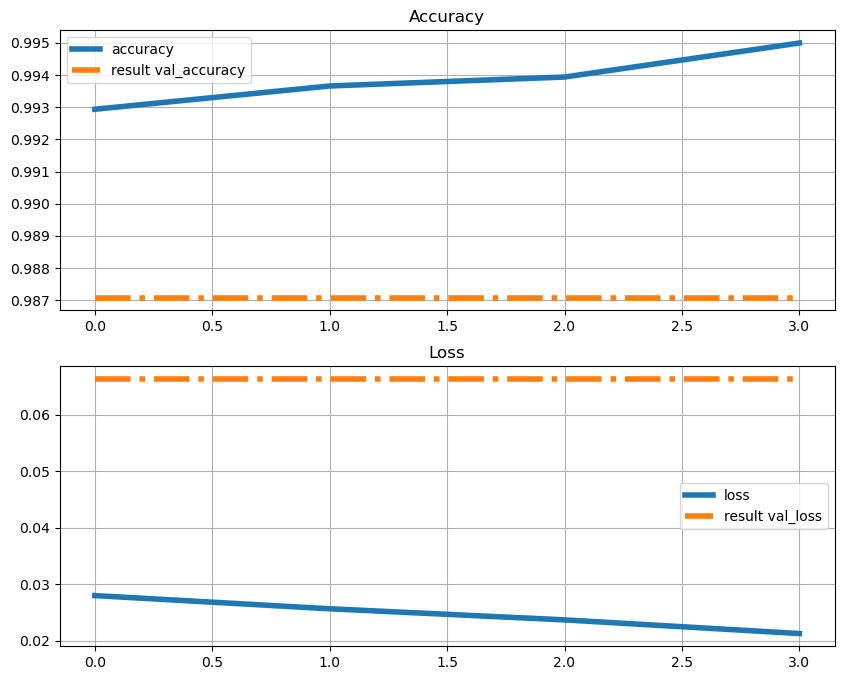

In [47]:
fig, axs = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(8)

axs[0].set_title('Accuracy')
axs[0].plot(history.epoch, history.history['accuracy'], linewidth=4, label='accuracy')
try:
    axs[0].plot(history.epoch, history.history['val_accuracy'], linewidth=4, label='val_accuracy')
except KeyError:
    axs[0].plot(history.epoch, np.ones(len(history.epoch))*val_acc, linewidth=4, linestyle='-.', label='result val_accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Loss')
axs[1].plot(history.epoch, history.history['loss'], linewidth=4, label='loss')
try:
    axs[1].plot(history.epoch, history.history['val_loss'], linewidth=4, label='val_loss')
except KeyError:
    axs[1].plot(history.epoch, np.ones(len(history.epoch))*val_loss, linewidth=4, linestyle='-.', label='result val_loss')
axs[1].legend()
axs[1].grid(True)

fig.show()